# Prelimina: resistance model identification

This notebook uses the Prelimina resistance curve stored in `data/prelimina.csv` (historically saved as `data/prelimia.csv` in this repo) to estimate and compare hull resistance surrogate models.

## Lumped coefficient model
$$R_T(V)=\frac{C_{Hull,T}\,(S_{Hull,air}\rho_{air}+S_{Hull,water}\rho_{water})\,V^2}{2}$$

## ITTC-based surrogate blocks
- Reynolds: $Re=VL/\nu$
- Froude: $Fr=V/\sqrt{gL}$
- ITTC-1957 friction line: $C_F=0.075/(\log_{10}Re-2)^2$
- Friction force: $R_F=0.5\,\rho\,S\,C_F\,V^2$
- Form factor: $R_V=(1+k)R_F$ and coefficient decomposition $C_W=C_T-(1+k)C_F$


## Equation references (allowed sources)

- Kinematic viscosity: $\nu=\mu/\rho$
  - Birk, *Fundamentals of Ship Hydrodynamics* (2019), Eq. (3.12), printed p. 30 (PDF p. 61).
  - Molland et al., *Ship Resistance and Propulsion* (2017), Nomenclature, printed p. xxiv (PDF p. 25).
- Reynolds number: $Re=VL/\nu$
  - Birk (2019), Eq. (2.13), printed p. 15 (PDF p. 46).
- Froude number: $Fr=V/\sqrt{gL}$
  - Birk (2019), Eq. (2.10), printed p. 14 (PDF p. 45).
- ITTC-1957 friction line: $C_F=0.075/(\log_{10}Re-2)^2$
  - Birk (2019), Eq. (2.18), printed p. 16 (PDF p. 47).
  - Molland et al. (2017), Eq. (4.15), printed p. 79 (PDF p. 110).
- Frictional resistance: $R_F=0.5\,\rho\,S\,C_F\,V^2$
  - Birk (2019), Eq. (2.19), printed p. 16 (PDF p. 47).
- Form factor / viscous resistance: $R_V=(1+k)R_F$ and $C_W=C_T-(1+k)C_F$
  - Birk (2019), Eq. (2.20) and Eq. (2.22)–(2.23), printed p. 16 (PDF p. 47).
- Air resistance coefficient form (supports $C_dA \equiv C_DA$·area and $R_{air}=0.5\,\rho_{air}\,(C_dA)\,V^2$):
  - Molland et al. (2017), Eq. (3.53), printed p. 49 (PDF p. 80).
  - Birk (2019), Eq. (30.5), printed p. 359 (PDF p. 390).
- Holtrop(-Mennen) calm-water resistance decomposition and components ($R_F$, $1+k$, $R_W$, $R_B$, $R_{TR}$, $R_A$):
  - Molland et al. (2017), Sec. 10.3.1.5, Eq. (10.24)–(10.34).
- Holtrop form factor regression ($1+k$) and auxiliary definitions (length of run):
  - Molland et al. (2017), Eq. (4.23)–(4.24).
- Hump/hollow phenomenon (wave interference; motivates fitting $C_W(Fr)$):
  - Molland et al. (2017), Sec. 3.1.5.4, printed p. 31 (PDF p. 62), Fig. 3.17.


In [32]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

sys.path.append('.')
sys.path.append('../../../')

from hydrostatic_hull import HydrostaticHull
from utils.optimization import load_model_params_from_json

from holtrop import HoltropInputs, holtrop_inputs_from_hull_params, holtrop_total_resistance
from helper import prepare_equilibrium_hull_mesh, compute_hull_metrics_at_trim_sinkage


In [33]:
USE_PRELIMINA_STATIC = False
PRELIMINA_CSV_DYNAMIC = Path('data') / 'prelimina.csv'
PRELIMINA_CSV_STATIC = Path('data') / 'prelimina_static.csv'

df_pre_dynamic = pd.read_csv(PRELIMINA_CSV_DYNAMIC) if PRELIMINA_CSV_DYNAMIC.exists() else None
df_pre_static = pd.read_csv(PRELIMINA_CSV_STATIC) if PRELIMINA_CSV_STATIC.exists() else None

PRELIMINA_CSV = PRELIMINA_CSV_STATIC if USE_PRELIMINA_STATIC else PRELIMINA_CSV_DYNAMIC
if not PRELIMINA_CSV.exists():
    PRELIMINA_CSV = PRELIMINA_CSV_DYNAMIC

df_pre = pd.read_csv(PRELIMINA_CSV)
print('PRELIMINA_CSV (models fitted to):', PRELIMINA_CSV)
print('Has prelimina.csv:', df_pre_dynamic is not None)
print('Has prelimina_static.csv:', df_pre_static is not None)

HULL_PARAMS_PATH = 'data/hull_input_params.json'
# HULL_PARAMS_PATH = 'data/hull_input_params_prelimina.json'  # Use this to replicate Prelimina's hydrostatic report.
hull_input_params = load_model_params_from_json(HULL_PARAMS_PATH)

hull = HydrostaticHull(
    cog_x=hull_input_params['cog_x'],
    disp_mass=hull_input_params['disp_mass'],
    total_area=hull_input_params['total_area'],
)
hull_params = hull.get_params()

display(df_pre.head())
print('hull_input_params:', hull_input_params)
print('hydrostatic hull_params:', hull_params)


PRELIMINA_CSV (models fitted to): data/prelimina.csv
Has prelimina.csv: True
Has prelimina_static.csv: True


,V (m/s),FnL,FnV,RT (N),PE (kW),CT (·10³),CP (·10³),CF (·10³),τ (°),s (mm)
0,0.00,0.000,0.000,0.000,0.0,NaN,NaN,NaN,0.0,0.000
1,0.01,0.001,0.004,0.002,0.0,10.190,0.000,10.190,-0.0,0.000
2,0.02,0.003,0.008,0.007,0.0,8.248,0.000,8.248,-0.0,0.000
3,0.03,0.004,0.012,0.015,0.0,7.580,0.220,7.359,-0.0,0.001
4,0.04,0.005,0.016,0.024,0.0,7.171,0.358,6.814,-0.0,0.001


hull_input_params: {'cog_x': 1.976, 'disp_mass': 293.7, 'total_area': 8.2384008863907}
hydrostatic hull_params: {'LWL': 5.116124628505016, 'BWL': 1.0152722270606231, 'AWP': 3.787593961979288, 'CWP': 0.7383341218989855, 'CB': 0.40288607944614724, 'CM': 0.4054342538643851, 'CP': 1.036120782955436, 'lcb_percent': -12.244640307860422, 'disp_volume_m3': 0.2865365853658536, 'draft_mean_m': 0.053292612213034204, 'draft_aft_m': 0.10536767080293857, 'draft_fwd_m': 0.0012175536231298371, 'draft_keel_m': 0.1423721956888262, 'A_mid_m2': 0.05639367853990717, 'total_area': 8.2384008863907, 'wet_surface_area_interp': 4.050226176680205, 'trim_angle_interp': -1.7719960366028298, 'cog_x': 1.976, 'disp_mass': 293.7}


In [34]:
# Fluid properties
water_rho = 1023
air_rho = 1.1839
water_mu = 0.0009268
water_nu = water_mu / water_rho
print('water_nu:', water_nu)

S_hull_water = float(hull_params['wet_surface_area_interp'])
S_hull_total = float(hull_params['total_area'])
S_hull_air = float(max(S_hull_total - S_hull_water, 0.0))

A_rho = S_hull_air * air_rho + S_hull_water * water_rho
print('S_hull_water (wet):', S_hull_water)
print('S_hull_air (proxy):', S_hull_air)
print('(S*rho) term:', A_rho, 'kg/m')


water_nu: 9.05962854349951e-07
S_hull_water (wet): 4.050226176680205
S_hull_air (proxy): 4.188174709710495
(S*rho) term: 4148.339758782676 kg/m


In [35]:
def _extract_curve(df: pd.DataFrame):
    V = pd.to_numeric(df['V (m/s)'], errors='coerce').to_numpy(dtype=float)
    RT = pd.to_numeric(df['RT (N)'], errors='coerce').to_numpy(dtype=float)
    mask = np.isfinite(V) & np.isfinite(RT) & (V > 0)
    return V[mask], RT[mask]

V_prelimina_dynamic, RT_prelimina_dynamic = (np.array([]), np.array([]))
V_prelimina_static, RT_prelimina_static = (np.array([]), np.array([]))
if df_pre_dynamic is not None:
    V_prelimina_dynamic, RT_prelimina_dynamic = _extract_curve(df_pre_dynamic)
if df_pre_static is not None:
    V_prelimina_static, RT_prelimina_static = _extract_curve(df_pre_static)

V = pd.to_numeric(df_pre['V (m/s)'], errors='coerce').to_numpy(dtype=float)
RT = pd.to_numeric(df_pre['RT (N)'], errors='coerce').to_numpy(dtype=float)
trim_deg = pd.to_numeric(df_pre['τ (°)'], errors='coerce').to_numpy(dtype=float)
sink_mm = pd.to_numeric(df_pre['s (mm)'], errors='coerce').to_numpy(dtype=float)

mask = np.isfinite(V) & np.isfinite(RT) & np.isfinite(trim_deg) & np.isfinite(sink_mm) & (V > 0)
V = V[mask]
RT = RT[mask]
trim_deg = trim_deg[mask]
sink_mm = sink_mm[mask]

L_ref = float(hull_params.get('LWL', np.nan))
if not np.isfinite(L_ref) or L_ref <= 0:
    raise ValueError('Invalid LWL from HydrostaticHull')

S_wet = float(S_hull_water)
g = 9.80665

V_MIN_FOR_FIT = 2.0  # [ASSUMPTION]
fit_mask = V >= V_MIN_FOR_FIT
V_fit = V[fit_mask]
RT_fit = RT[fit_mask]


C_Hull,T median (V >= 2.0 m/s): 0.004253789049137573
RMSE RT (N): 94.88170906419286
MAE  RT (N): 54.395609544895365
RMSE/mean(RT): 0.37135319264494177


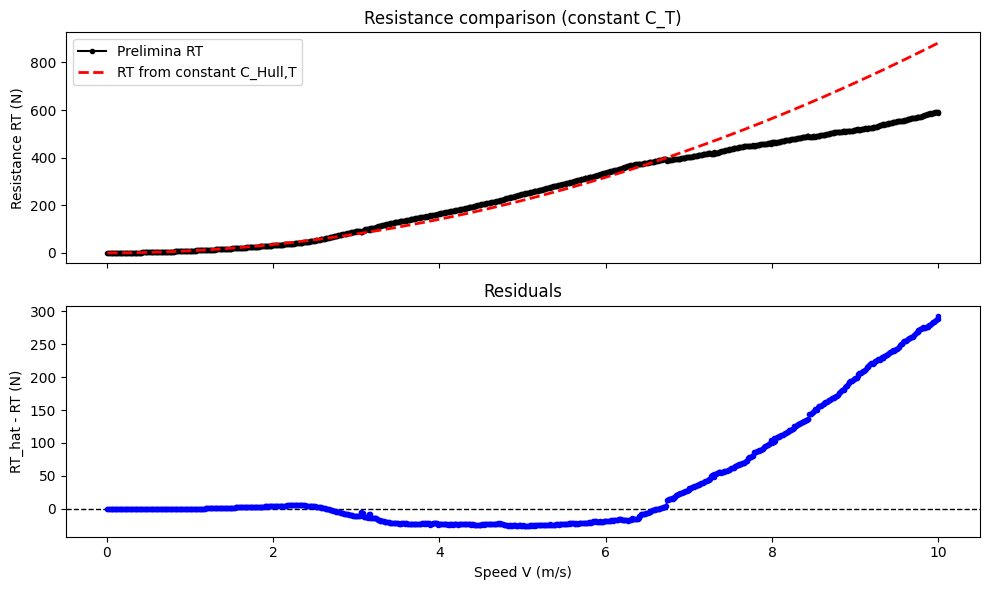

In [36]:
# Constant C_T model
C_T = 2.0 * RT / (A_rho * V**2)
C_T_med = float(np.nanmedian(C_T[fit_mask]))
print('C_Hull,T median (V >=', V_MIN_FOR_FIT, 'm/s):', C_T_med)

RT_hat = 0.5 * C_T_med * A_rho * V**2
RT_const_ct = RT_hat
residual = RT_hat - RT

rmse_R = float(np.sqrt(np.mean(residual**2)))
mae_R = float(np.mean(np.abs(residual)))
rel_rmse = float(rmse_R / np.mean(RT))
print('RMSE RT (N):', rmse_R)
print('MAE  RT (N):', mae_R)
print('RMSE/mean(RT):', rel_rmse)

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].plot(V, RT, 'k-o', markersize=3, label='Prelimina RT')
ax[0].plot(V, RT_hat, 'r--', linewidth=2, label='RT from constant C_Hull,T')
ax[0].set_ylabel('Resistance RT (N)')
ax[0].set_title('Resistance comparison (constant C_T)')
ax[0].legend(loc='upper left')

ax[1].axhline(0, color='k', linestyle='--', linewidth=1)
ax[1].plot(V, residual, 'b-o', markersize=3)
ax[1].set_xlabel('Speed V (m/s)')
ax[1].set_ylabel('RT_hat - RT (N)')
ax[1].set_title('Residuals')

plt.tight_layout()
plt.show()


## ITTC friction + $C_4 V^4$ residual (reference)
This is kept as a reference baseline.


k_form: 0.47902026323825525
CdA (m^2): 3.161866293184549e-17
C4: 6.377356168603951e-26
RMSE RT (N): 43.137808009908476
MAE  RT (N): 33.23004846132615
RMSE/mean(RT): 0.16883509884234954


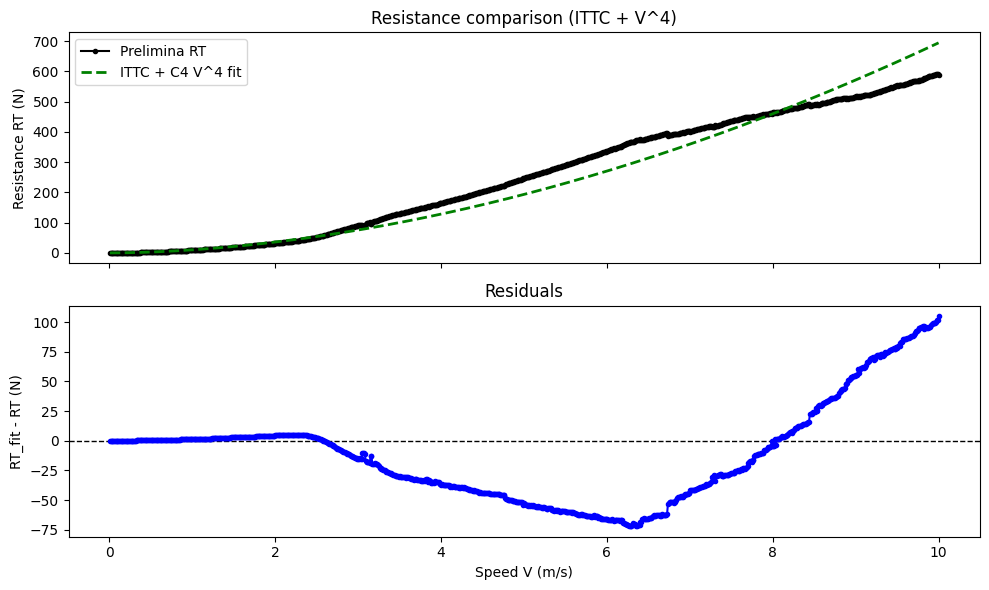

In [37]:
def ittc_cf(Re):
    Re = np.maximum(Re, 1.0)
    return 0.075 / (np.log10(Re) - 2.0) ** 2

def rt_ittc_v4(theta, V):
    k_form, CdA, C4 = theta
    V = np.asarray(V, dtype=float)
    Re = V * L_ref / water_nu
    Cf = ittc_cf(Re)
    R_fric = 0.5 * water_rho * S_wet * (1.0 + k_form) * Cf * V**2
    R_air = 0.5 * air_rho * CdA * V**2
    R_res = C4 * V**4
    return R_fric + R_air + R_res

theta0 = np.array([0.2, 0.3, 0.0], dtype=float)
lb = np.array([0.0, 0.0, 0.0], dtype=float)
ub = np.array([10.0, 50.0, 1e3], dtype=float)
res = least_squares(lambda th: rt_ittc_v4(th, V_fit) - RT_fit, x0=theta0, bounds=(lb, ub), loss='soft_l1', f_scale=50.0)
k_form, CdA, C4 = res.x
print('k_form:', float(k_form))
print('CdA (m^2):', float(CdA))
print('C4:', float(C4))

RT_ittc = rt_ittc_v4(res.x, V)
RT_ittc_v4 = RT_ittc
residual_ittc = RT_ittc - RT
rmse_R = float(np.sqrt(np.mean(residual_ittc**2)))
mae_R = float(np.mean(np.abs(residual_ittc)))
rel_rmse = float(rmse_R / np.mean(RT))
print('RMSE RT (N):', rmse_R)
print('MAE  RT (N):', mae_R)
print('RMSE/mean(RT):', rel_rmse)

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].plot(V, RT, 'k-o', markersize=3, label='Prelimina RT')
ax[0].plot(V, RT_ittc, 'g--', linewidth=2, label='ITTC + C4 V^4 fit')
ax[0].set_ylabel('Resistance RT (N)')
ax[0].set_title('Resistance comparison (ITTC + V^4)')
ax[0].legend(loc='upper left')

ax[1].axhline(0, color='k', linestyle='--', linewidth=1)
ax[1].plot(V, residual_ittc, 'b-o', markersize=3)
ax[1].set_xlabel('Speed V (m/s)')
ax[1].set_ylabel('RT_fit - RT (N)')
ax[1].set_title('Residuals')

plt.tight_layout()
plt.show()


## ITTC-supported $C_W(Fr)$ model (recommended)

This uses the ITTC decomposition to compute $C_W$ from the data and then fairs $C_W(Fr)$ by interpolation.
No unsupported analytic hump is introduced.


Prohaska k_form: 0.27616172033638
RMSE RT (N): 3.7379003136532742
MAE  RT (N): 2.4413169245434108
RMSE/mean(RT): 0.014629597516256341


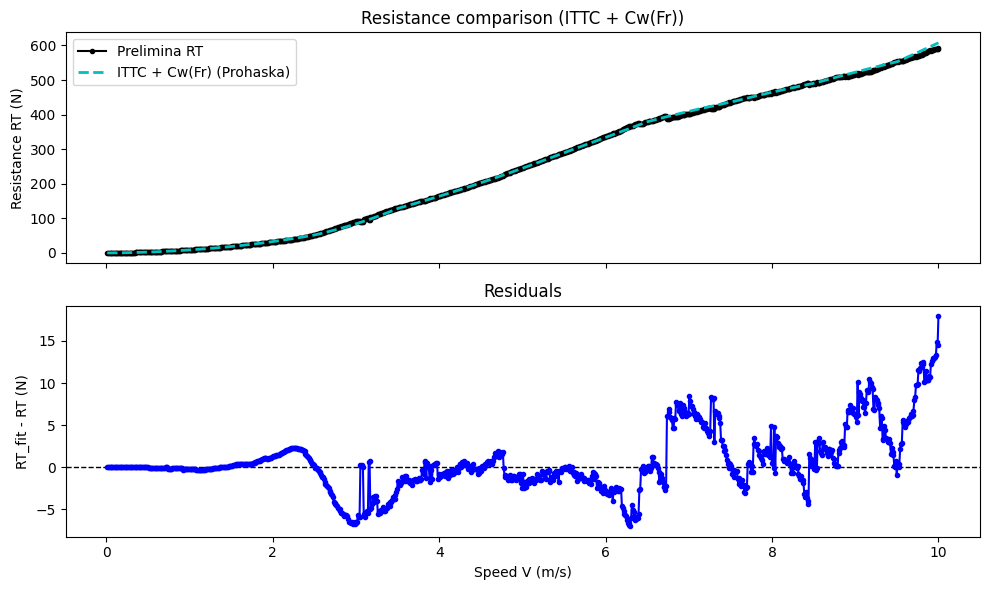

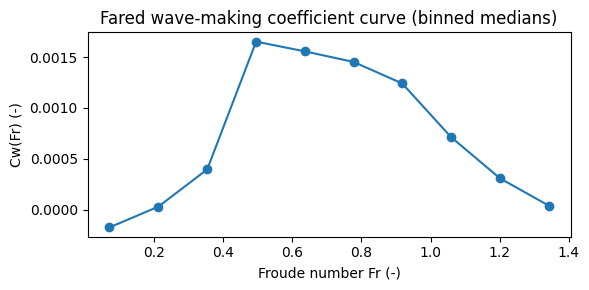

In [38]:
Re = V * L_ref / water_nu
Cf = ittc_cf(Re)
CT = RT / (0.5 * water_rho * S_wet * V**2)
Fr = V / np.sqrt(g * L_ref)

# Prohaska method to estimate k_form from low-Fr range
mask_p = (Fr >= 0.10) & (Fr <= 0.20)
if int(np.sum(mask_p)) < 10:
    mask_p = (Fr >= 0.05) & (Fr <= 0.25)

x_p = (Fr[mask_p] ** 4) / Cf[mask_p]
y_p = CT[mask_p] / Cf[mask_p]
coef = np.polyfit(x_p, y_p, deg=1)
k_form = float(coef[1] - 1.0)
print('Prohaska k_form:', k_form)

Cw = CT - (1.0 + k_form) * Cf

N_BINS = 10
edges = np.linspace(float(np.min(Fr)), float(np.max(Fr)), N_BINS + 1)
bin_id = pd.cut(Fr, bins=edges, labels=False, include_lowest=True)
grouped = pd.DataFrame({'bin': bin_id, 'Fr': Fr, 'Cw': Cw}).groupby('bin').agg(
    Fr_mean=('Fr', 'mean'),
    Cw_median=('Cw', 'median'),
    n=('Cw', 'size'),
)
grouped = grouped[grouped['n'] >= 10].dropna()

Fr_knots = grouped['Fr_mean'].to_numpy(dtype=float)
Cw_knots = grouped['Cw_median'].to_numpy(dtype=float)
order = np.argsort(Fr_knots)
Fr_knots = Fr_knots[order]
Cw_knots = Cw_knots[order]

Cw_fit = np.interp(Fr, Fr_knots, Cw_knots)
RT_cw = 0.5 * water_rho * S_wet * ((1.0 + k_form) * Cf + Cw_fit) * V**2
RT_ittc_cw = RT_cw
residual_cw = RT_cw - RT

rmse_R = float(np.sqrt(np.mean(residual_cw**2)))
mae_R = float(np.mean(np.abs(residual_cw)))
rel_rmse = float(rmse_R / np.mean(RT))
print('RMSE RT (N):', rmse_R)
print('MAE  RT (N):', mae_R)
print('RMSE/mean(RT):', rel_rmse)

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].plot(V, RT, 'k-o', markersize=3, label='Prelimina RT')
ax[0].plot(V, RT_cw, 'c--', linewidth=2, label='ITTC + Cw(Fr) (Prohaska)')
ax[0].set_ylabel('Resistance RT (N)')
ax[0].set_title('Resistance comparison (ITTC + Cw(Fr))')
ax[0].legend(loc='upper left')

ax[1].axhline(0, color='k', linestyle='--', linewidth=1)
ax[1].plot(V, residual_cw, 'b-o', markersize=3)
ax[1].set_xlabel('Speed V (m/s)')
ax[1].set_ylabel('RT_fit - RT (N)')
ax[1].set_title('Residuals')

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(Fr_knots, Cw_knots, marker='o')
plt.xlabel('Froude number Fr (-)')
plt.ylabel('Cw(Fr) (-)')
plt.title('Fared wave-making coefficient curve (binned medians)')
plt.tight_layout()
plt.show()


## Holtrop(-Mennen) calm-water resistance (validation vs Prelimina curve)

This section validates our Holtrop(-Mennen) implementation (Molland et al., 2017, Eq. (10.24)–(10.34)) against the Prelimina resistance curve in `data/prelimina.csv`, using `data/hull_input_params_prelimina.json` to replicate Prelimina's operating point.

This validation uses Prelimina's reported running attitude columns (`τ (°)` and `s (mm)`) to recompute the hull geometry inputs used by Holtrop at each speed.

[ASSUMPTION] Interpret `τ` and `s` as rigid-body pitch (about the CoG x-position) and heave; `s>0` moves the hull upward (reducing immersion) relative to the equilibrium pose.
[ASSUMPTION] Recompute `LWL`, `BWL`, drafts (`T`, `TA`, `TF`) and wetted area `S` from the mesh under the running attitude; keep shape coefficients (`CWP`, `CP`, `CM`, `LCB%`) and displacement volume `∇` fixed from the equilibrium operating point.
[ASSUMPTION] Use `draft_keel_m` as `T` (representative draft) for Holtrop to avoid pathological behavior at very low speeds.
[ASSUMPTION] If `TA` or `TF` is non-positive, fall back to `T` for that end.
[ASSUMPTION] Compute dynamic hydrostatics on a decimated speed grid and interpolate to all speeds (see `DECIMATE_STRIDE`).


HULL_PARAMS_PATH: data/hull_input_params_prelimina.json
STL_PATH: data/hull_decimated.stl
DECIMATE_STRIDE: 10
hull_input_params: {'cog_x': 2.603, 'disp_mass': 246.0, 'total_area': 8.2384008863907}
inputs_base: HoltropInputs(LWL=5.869758544354894, B=0.9514458737998119, T=0.1132276298607503, TA=0.1132276298607503, TF=0.1132276298607503, volume=0.24, CP=0.6360183319455008, CM=0.6013354246092799, CWP=0.7067872960939554, LCB_percent=-5.722003907230018, S=4.128783745252358, AT=0.0, ABT=0.0, hB=0.0, Cstern=0.0, rho=1023.0, nu=9.05962854349951e-07, g=9.80665)
RMSE RT (N): 77.22186828201093
MAE  RT (N): 56.97414259670659
RMSE/mean(RT): 0.3022351474416485


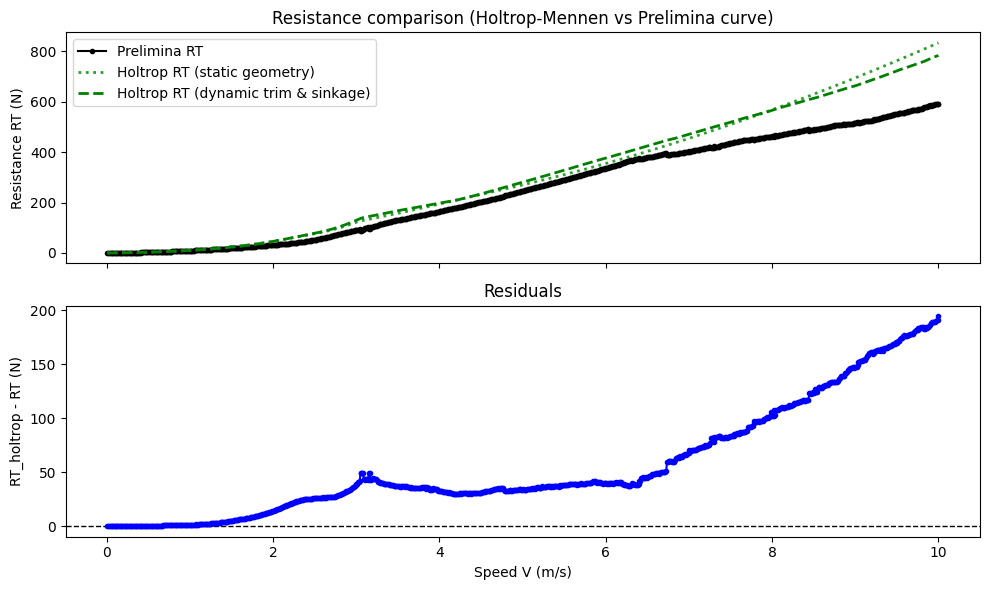

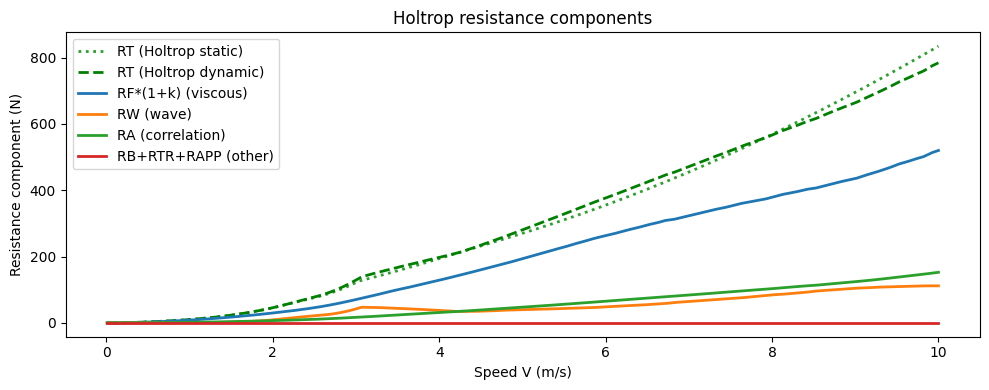

In [39]:
HULL_PARAMS_PATH = 'data/hull_input_params_prelimina.json'
hull_input_params = load_model_params_from_json(HULL_PARAMS_PATH)

STL_PATH = Path('data') / 'hull_decimated.stl'
hull = HydrostaticHull(
    cog_x=hull_input_params['cog_x'],
    disp_mass=hull_input_params['disp_mass'],
    total_area=hull_input_params['total_area'],
)
hull_params = hull.get_params()

base_mesh = prepare_equilibrium_hull_mesh(
    str(STL_PATH),
    cog_x=hull_input_params['cog_x'],
    volume_m3=float(hull_params['disp_volume_m3']),
    trim_deg=float(hull_params['trim_angle_interp']),
)

inputs_base = holtrop_inputs_from_hull_params(
    hull_params,
    rho=water_rho,
    nu=water_nu,
    g=g,
    Cstern=0.0,
    use_end_drafts=False,
)
RT_holtrop_static = holtrop_total_resistance(inputs_base, V)['RT']

DECIMATE_STRIDE = 10  # [ASSUMPTION] Compute dynamic hydrostatics on a decimated grid and interpolate.
idx = np.arange(0, len(V), DECIMATE_STRIDE, dtype=int)
if idx[-1] != len(V) - 1:
    idx = np.concatenate([idx, np.array([len(V) - 1], dtype=int)])

V_s = V[idx]
trim_s = trim_deg[idx]
sink_s = sink_mm[idx] * 1e-3

metrics_s = [
    compute_hull_metrics_at_trim_sinkage(
        base_mesh,
        cog_x=hull_input_params['cog_x'],
        trim_deg=float(t),
        sink_m=float(s),
    )
    for t, s in zip(trim_s, sink_s)
]

def _series(key: str):
    return np.array([m.get(key, np.nan) for m in metrics_s], dtype=float)

LWL_s = _series('LWL')
BWL_s = _series('BWL')
T_s = _series('draft_keel_m')
TA_s = _series('draft_aft_m')
TF_s = _series('draft_fwd_m')
S_s = _series('wet_surface_area')

LWL_i = np.interp(V, V_s, LWL_s)
BWL_i = np.interp(V, V_s, BWL_s)
T_i = np.interp(V, V_s, T_s)
TA_i = np.interp(V, V_s, TA_s)
TF_i = np.interp(V, V_s, TF_s)
S_i = np.interp(V, V_s, S_s)

TA_i = np.where(TA_i > 0, TA_i, T_i)
TF_i = np.where(TF_i > 0, TF_i, T_i)

RT_holtrop = np.zeros_like(V, dtype=float)
R_visc = np.zeros_like(V, dtype=float)
R_wave = np.zeros_like(V, dtype=float)
R_corr = np.zeros_like(V, dtype=float)
R_other = np.zeros_like(V, dtype=float)

for i in range(len(V)):
    inputs_i = HoltropInputs(
        LWL=float(LWL_i[i]),
        B=float(BWL_i[i]),
        T=float(T_i[i]),
        TA=float(TA_i[i]),
        TF=float(TF_i[i]),
        volume=float(inputs_base.volume),
        CP=float(inputs_base.CP),
        CM=float(inputs_base.CM),
        CWP=float(inputs_base.CWP),
        LCB_percent=float(inputs_base.LCB_percent),
        S=float(S_i[i]),
        rho=float(inputs_base.rho),
        nu=float(inputs_base.nu),
        g=float(inputs_base.g),
    )
    comp_i = holtrop_total_resistance(inputs_i, np.array([V[i]], dtype=float))
    RT_holtrop[i] = float(comp_i['RT'][0])
    R_visc[i] = float(comp_i['RF'][0] * comp_i['one_k'][0])
    R_wave[i] = float(comp_i['RW'][0])
    R_corr[i] = float(comp_i['RA'][0])
    R_other[i] = float(comp_i['RB'][0] + comp_i['RTR'][0] + comp_i['RAPP'][0])

print('HULL_PARAMS_PATH:', HULL_PARAMS_PATH)
print('STL_PATH:', STL_PATH)
print('DECIMATE_STRIDE:', DECIMATE_STRIDE)
print('hull_input_params:', hull_input_params)
print('inputs_base:', inputs_base)

residual = RT_holtrop - RT
rmse_R = float(np.sqrt(np.mean(residual**2)))
mae_R = float(np.mean(np.abs(residual)))
rel_rmse = float(rmse_R / np.mean(RT))
print('RMSE RT (N):', rmse_R)
print('MAE  RT (N):', mae_R)
print('RMSE/mean(RT):', rel_rmse)

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].plot(V, RT, 'k-o', markersize=3, label='Prelimina RT')
ax[0].plot(V, RT_holtrop_static, color='tab:green', linestyle=':', linewidth=2, label='Holtrop RT (static geometry)')
ax[0].plot(V, RT_holtrop, 'g--', linewidth=2, label='Holtrop RT (dynamic trim & sinkage)')
ax[0].set_ylabel('Resistance RT (N)')
ax[0].set_title('Resistance comparison (Holtrop-Mennen vs Prelimina curve)')
ax[0].legend(loc='upper left')

ax[1].axhline(0, color='k', linestyle='--', linewidth=1)
ax[1].plot(V, residual, 'b-o', markersize=3)
ax[1].set_xlabel('Speed V (m/s)')
ax[1].set_ylabel('RT_holtrop - RT (N)')
ax[1].set_title('Residuals')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(V, RT_holtrop_static, color='tab:green', linestyle=':', linewidth=2, label='RT (Holtrop static)')
plt.plot(V, RT_holtrop, 'g--', linewidth=2, label='RT (Holtrop dynamic)')
plt.plot(V, R_visc, linewidth=2, label='RF*(1+k) (viscous)')
plt.plot(V, R_wave, linewidth=2, label='RW (wave)')
plt.plot(V, R_corr, linewidth=2, label='RA (correlation)')
plt.plot(V, R_other, linewidth=2, label='RB+RTR+RAPP (other)')
plt.xlabel('Speed V (m/s)')
plt.ylabel('Resistance component (N)')
plt.title('Holtrop resistance components')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


## Comparison (all methods)

This figure overlays the surrogate models defined above for a single visual check.


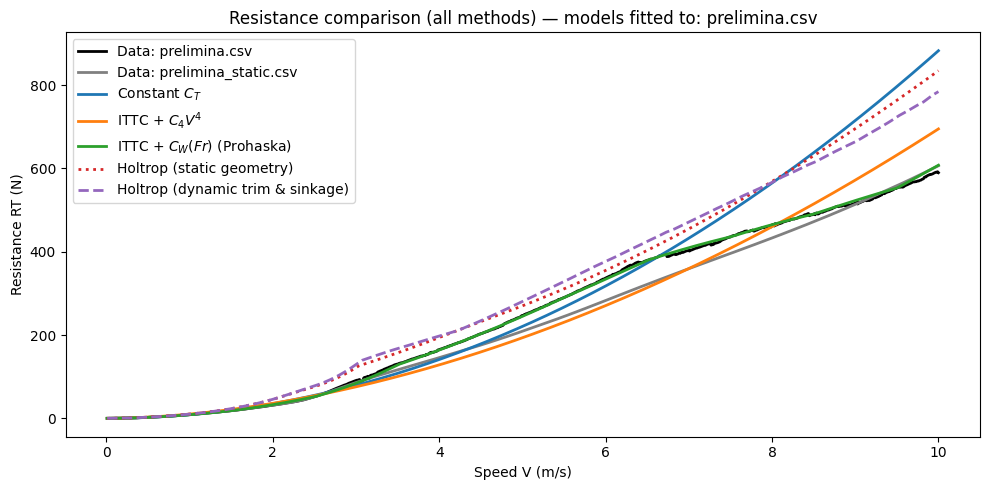

In [47]:
plt.figure(figsize=(10, 5))
if 'V_prelimina_dynamic' in globals() and len(V_prelimina_dynamic) > 0:
    plt.plot(V_prelimina_dynamic, RT_prelimina_dynamic, color='k', linewidth=2, label='Data: prelimina.csv')
if 'V_prelimina_static' in globals() and len(V_prelimina_static) > 0:
    plt.plot(V_prelimina_static, RT_prelimina_static, color='0.5', linewidth=2, label='Data: prelimina_static.csv')

if 'RT_const_ct' in globals():
    plt.plot(V, RT_const_ct, linewidth=2, label='Constant $C_T$')

if 'RT_ittc_v4' in globals():
    plt.plot(V, RT_ittc_v4, linewidth=2, label='ITTC + $C_4 V^4$')

if 'RT_ittc_cw' in globals():
    plt.plot(V, RT_ittc_cw, linewidth=2, label='ITTC + $C_W(Fr)$ (Prohaska)')

if 'RT_holtrop_static' in globals():
    plt.plot(V, RT_holtrop_static, linestyle=':', linewidth=2, label='Holtrop (static geometry)')

if 'RT_holtrop' in globals():
    plt.plot(V, RT_holtrop, linestyle='--', linewidth=2, label='Holtrop (dynamic trim & sinkage)')

plt.xlabel('Speed V (m/s)')
plt.ylabel('Resistance RT (N)')
plt.title(f'Resistance comparison (all methods) — models fitted to: {PRELIMINA_CSV.name}')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
